In [1]:
# 1. Основные библиотеки
import numpy as np
import pandas as pd
import pickle   # сохранение модели
import os

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline



# 2. Разделение датасета и препроцесинг
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.impute import SimpleImputer

# 3. Модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso

# 4. Метрики качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

# 5. Для визуализации внешних картинок в ноутбуке
from IPython.display import Image

import warnings
warnings.filterwarnings('ignore')

### Описания полей датасета по недвижимости

* Id - идентификационный номер квартиры,

* DistrictId - идентификационный номер района,

* Rooms - количество комнат,

* Square - площадь,

* LifeSquare - жилая площадь,

* KitchenSquare - площадь кухни,

* Floor - этаж,

* HouseFloor - количество этажей в доме,

* HouseYear - год постройки дома,

* Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности,

* Social_1, Social_2, Social_3 - социальные показатели местности,

* Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья,

* Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров,

* Price - цена квартиры.

In [2]:
matplotlib.rcParams.update({'font.size': 14}) 

In [3]:
DATASET_PATH = r'C:\Users\Оксана\Downloads\train.csv'
PREPARED_DATASET_PATH = 'housing_prepared.csv'
TEST = r'C:\Users\Оксана\Downloads\test.csv'


In [4]:
df = pd.read_csv(DATASET_PATH, sep=',')

In [5]:
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [6]:
df = df.drop(['Id'], axis=1) # удалим встроеный id
df.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     10000 non-null  int64  
 1   Rooms          10000 non-null  float64
 2   Square         10000 non-null  float64
 3   LifeSquare     7887 non-null   float64
 4   KitchenSquare  10000 non-null  float64
 5   Floor          10000 non-null  int64  
 6   HouseFloor     10000 non-null  float64
 7   HouseYear      10000 non-null  int64  
 8   Ecology_1      10000 non-null  float64
 9   Ecology_2      10000 non-null  object 
 10  Ecology_3      10000 non-null  object 
 11  Social_1       10000 non-null  int64  
 12  Social_2       10000 non-null  int64  
 13  Social_3       10000 non-null  int64  
 14  Healthcare_1   5202 non-null   float64
 15  Helthcare_2    10000 non-null  int64  
 16  Shops_1        10000 non-null  int64  
 17  Shops_2        10000 non-null  object 
 18  Price  

## Оптимизация памяти

In [7]:
def reduce_mem_usage(df):
    """ проходим по всем колонкам дата фрейма и оптимезируем тип данных в соответствии с диапазоном данных.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [8]:
reduce_mem_usage(df)

Memory usage of dataframe is 1.45 MB
Memory usage after optimization is: 0.47 MB
Decreased by 67.7%


,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.937500
1,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.437500
2,53,2.0,44.947952,29.197611,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.906250
3,58,2.0,53.352982,52.731510,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.234375
4,99,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,32,2.0,50.401787,30.476204,5.0,6,5.0,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.312500
9996,18,1.0,41.521545,20.539215,9.0,13,13.0,2000,0.000000,B,B,30,5562,0,NaN,0,5,A,189050.296875
9997,27,1.0,47.939007,NaN,1.0,12,16.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,159143.812500
9998,75,2.0,43.602562,33.840149,8.0,1,5.0,1961,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.343750


##  Проверка Дубликатов


In [9]:
print(f'Количество дублей {df[df.duplicated()].shape[0]} в нашем сете из {df.shape[0]}')
df.drop_duplicates(keep='first',inplace=True) # оставяем первый вариант
print(f'После удаления количество записей в наборе данных - {df.shape[0]}')

Количество дублей 0 в нашем сете из 10000
После удаления количество записей в наборе данных - 10000


## Замена пропусков

In [10]:
print(f'Процент пропусков в признаках\n{df.isnull().sum()*100/df.shape[0]}')

Процент пропусков в признаках
DistrictId        0.00
Rooms             0.00
Square            0.00
LifeSquare       21.13
KitchenSquare     0.00
Floor             0.00
HouseFloor        0.00
HouseYear         0.00
Ecology_1         0.00
Ecology_2         0.00
Ecology_3         0.00
Social_1          0.00
Social_2          0.00
Social_3          0.00
Healthcare_1     47.98
Helthcare_2       0.00
Shops_1           0.00
Shops_2           0.00
Price             0.00
dtype: float64


LifeSquare расчитаем из из того что LifeSquare находится в интервале от 0.5 до 0.7 по отношению к Square            
возьмем середину - 0.6
Healthcare_1- содержит слишком много пропусков отбросим признак

In [11]:
df['LifeSquare'].fillna(df['Square']*0.6, inplace=True)

In [12]:
df.drop(['Healthcare_1'], axis=1, inplace=True)

In [13]:
print(f'Процент пропусков в признаках после замены значений по медиане\n{df.isnull().sum()*100/df.shape[0]}')

Процент пропусков в признаках после замены значений по медиане
DistrictId       0.0
Rooms            0.0
Square           0.0
LifeSquare       0.0
KitchenSquare    0.0
Floor            0.0
HouseFloor       0.0
HouseYear        0.0
Ecology_1        0.0
Ecology_2        0.0
Ecology_3        0.0
Social_1         0.0
Social_2         0.0
Social_3         0.0
Helthcare_2      0.0
Shops_1          0.0
Shops_2          0.0
Price            0.0
dtype: float64


## Визуализация целевой переменой

In [14]:
target_mean = round(df['Price'].mean(), 2)
target_median = df['Price'].median()
target_mode = df['Price'].mode()[0]
target_bins = df['Price'] // 10000 * 10000
target_adjusted_mode = target_bins.mode()[0]

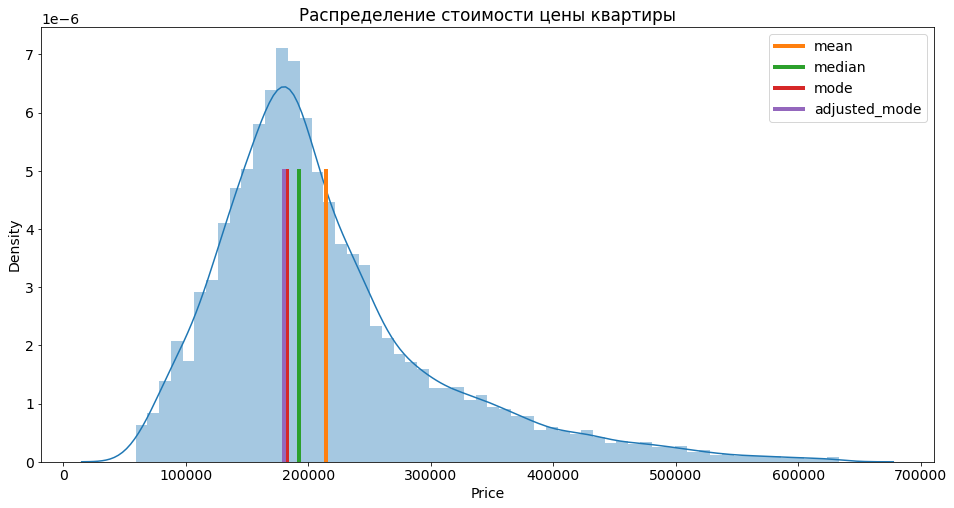

In [15]:
plt.figure(figsize = (16, 8))

sns.distplot(df['Price'], bins=60)

y = np.linspace(0, 0.000005, 10)
plt.plot([target_mean] * 10, y, label='mean', linewidth=4)
plt.plot([target_median] * 10, y, label='median', linewidth=4)
plt.plot([target_mode] * 10, y, label='mode', linewidth=4)
plt.plot([target_adjusted_mode]*10, y, label='adjusted_mode', linestyle='-', linewidth=4)

plt.title('Распределение стоимости цены квартиры')
plt.legend()
plt.show()

Распределение стоимости недвижимисти имет вид отличный от нормального с хвостом вправо

## Боксплоты для числовых признаков

In [16]:
df_num = df.select_dtypes(exclude=['category', 'object'])

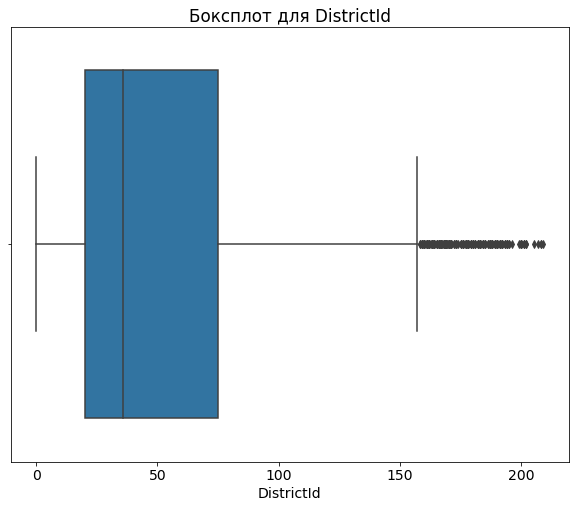

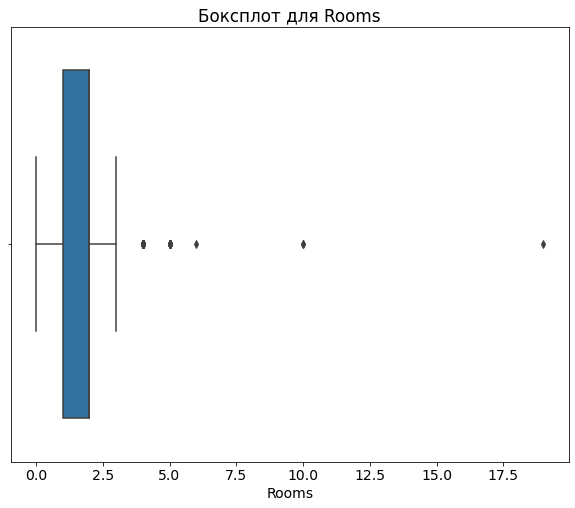

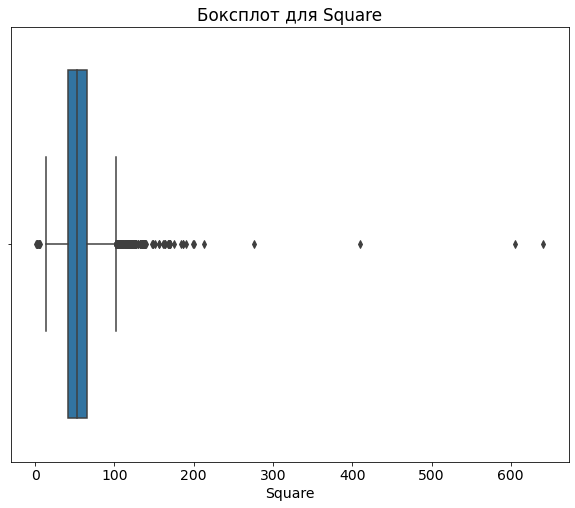

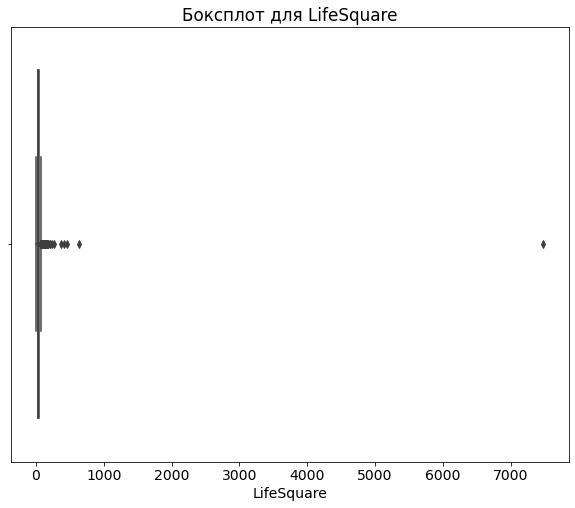

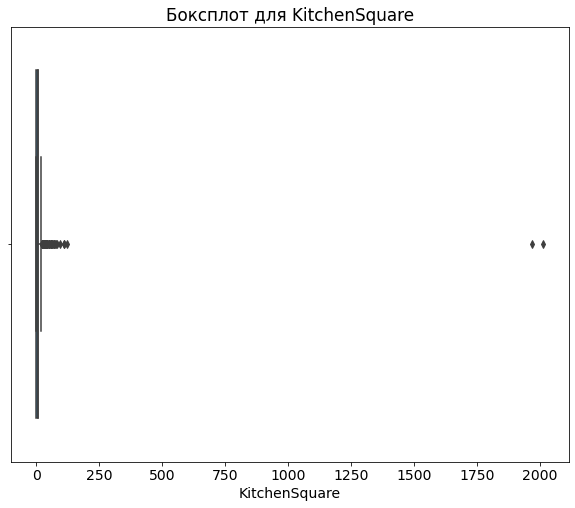

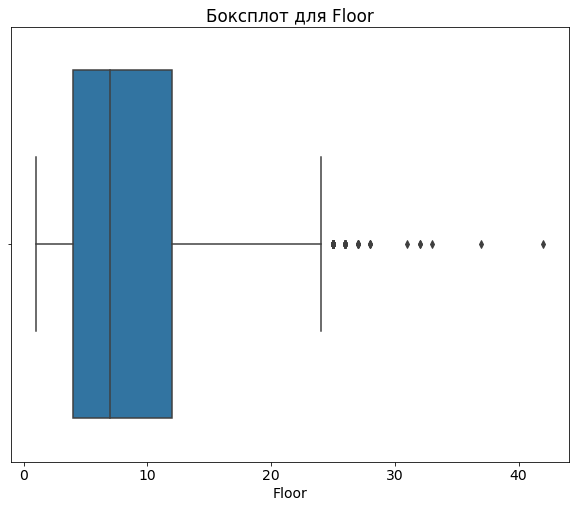

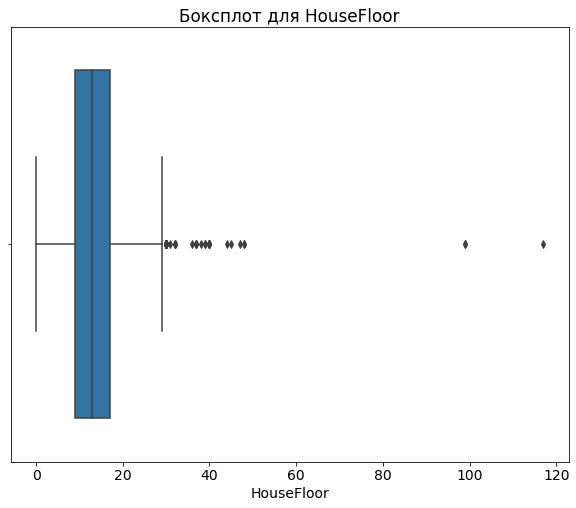

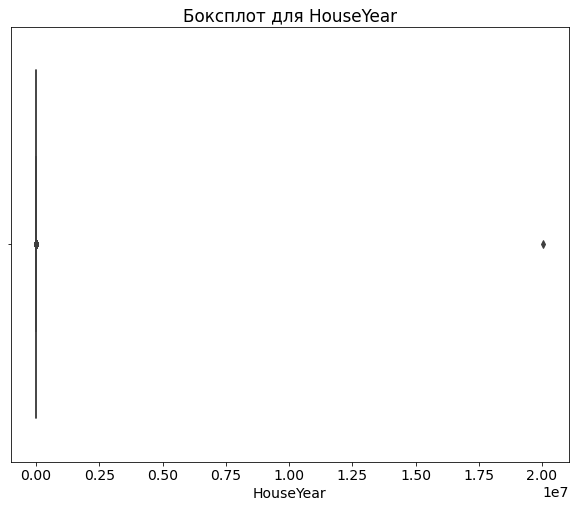

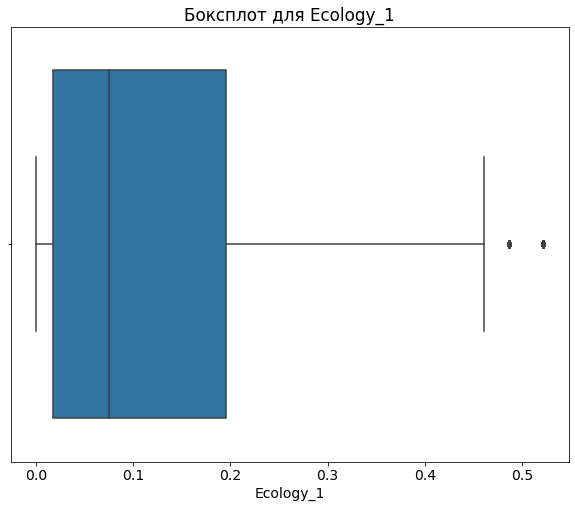

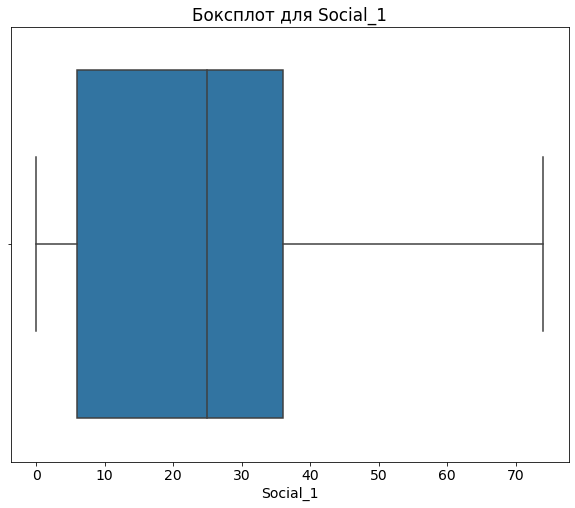

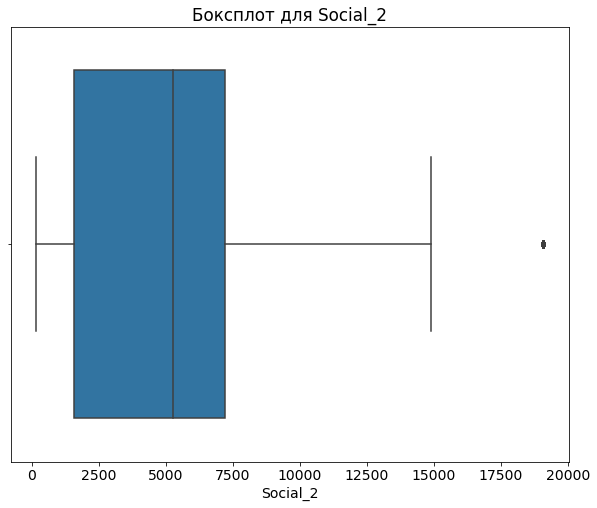

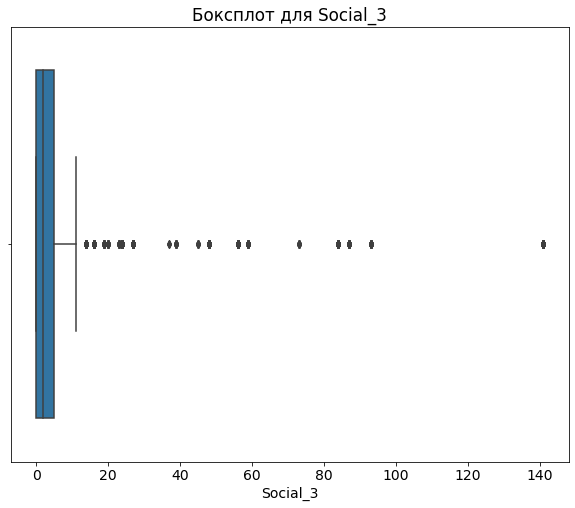

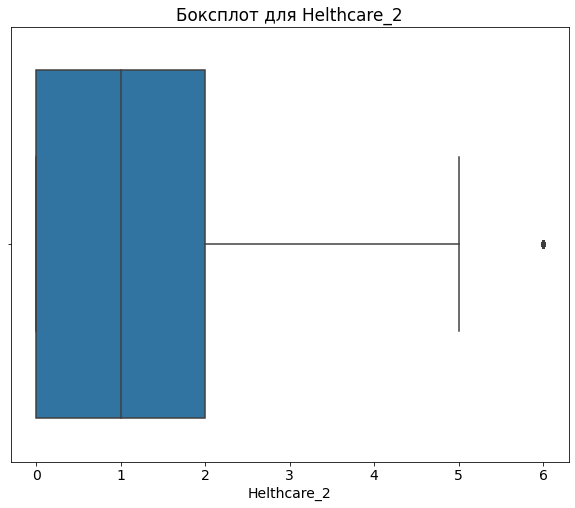

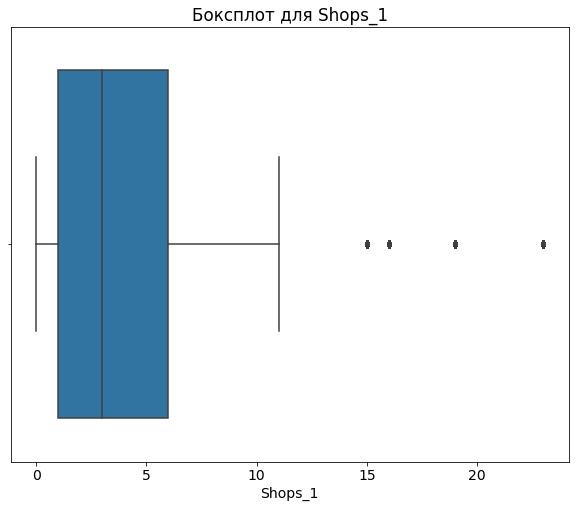

In [17]:
for el in df_num.columns[:-1]:
    plt.figure(figsize=(10, 8))
    sns.boxplot(df_num[el], whis=1.5)
    plt.title("Боксплот для " + str(el))
    

Наблюдаются вбросы в следующих признаках - DistrictId, Rooms, Square, lifeSquare, KitchenSquare, Floor, HouseFloor, HouseFloor, Ecology_1, Social_1, Social_2, Social_3, Healthcare_1, Helthcare_2, Shops_1, HouseYear
В 1ю очередь избавимся от самых существеных Rooms, Square, lifeSquare, KitchenSquare, HouseYear

 Уберем явные вбросы Square ограничем 7м2 LifeSquare 7м2 (cамая маленькая квартира в Москве имеет площадь 9 квадратных метров возьмем с запасом) HouseYear не более 2022 и не менее 1920 - год застройки Москвы, KitchenSquare не более 100 м2 LifeSquare 300 и Square 600

Не смотря на то что данные немного за границей количество комнат вполне может быть как 0(студия) так и 4. Площадь жилья в районе 140 так же как и жилая площадь в районе 80 может быть. Площадь кухни более 30 возможна в случае совместной планировки с гостиной. Этаж 100 и 120 возможен для элитного жилья. Ограничем количество округов 142 (125 районов и 21 поселения = 142 

In [18]:
df = df.loc[df['Square']>7]
df = df.loc[df['LifeSquare']>7]
df = df.loc[df['HouseYear']<2023]
df = df.loc[df['HouseYear']>1920]
df = df.loc[df['KitchenSquare']<100]
df = df.loc[df['LifeSquare']<300]
df = df.loc[df['Square']<600]
df = df.loc[df['DistrictId']<142]

In [20]:
feature_for_purifieng = ['Square', 'HouseYear', 'LifeSquare', 'KitchenSquare']

In [21]:
for el in feature_for_purifieng:
    Q1 = df[el].quantile(0.25)
    Q3 = df[el].quantile(0.75)
    IQR = Q3-Q1
    df = df[(df[el]<Q1-3*IQR)|(df[el]<Q3+3*IQR)]

In [22]:
print(f'Удадено {10000 - df.shape[0]} cстрок')
print(f'Удаленный процент датафрейма {(10000 - df.shape[0])*100/10000} %')

Удадено 771 cстрок
Удаленный процент датафрейма 7.71 %


In [23]:
df_num = df.select_dtypes(exclude=['category', 'object'])

## Боксплоты для Категориальных признаков

In [26]:
cat = df.select_dtypes(include=['category', 'object'])

In [27]:
cat['Price'] = df['Price'] 

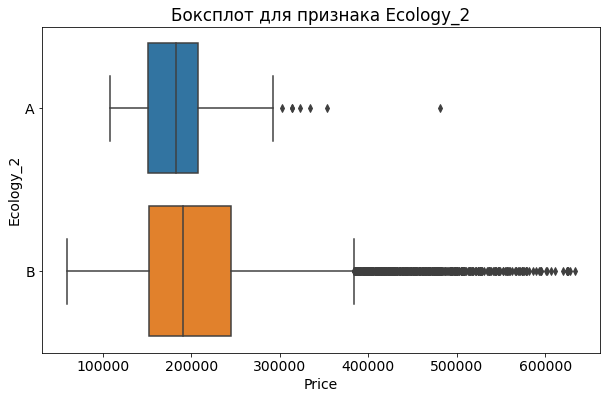

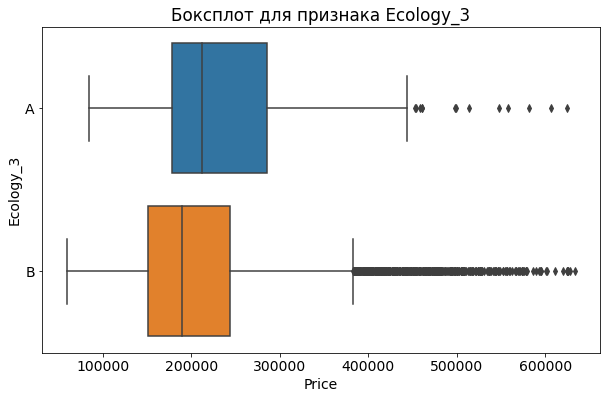

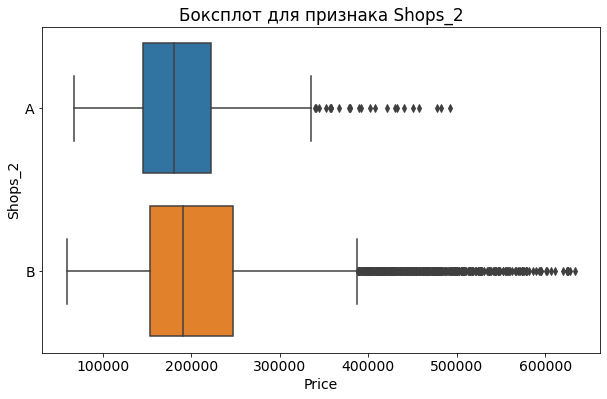

In [28]:
for el in cat.columns[:-1]:
    plt.figure(figsize=(10, 6))
    plt.title('Боксплот для признака ' + str(el))
    sns.boxplot(cat['Price'], cat[el], whis=1.5)
   

## Гистограма для числовых признаков

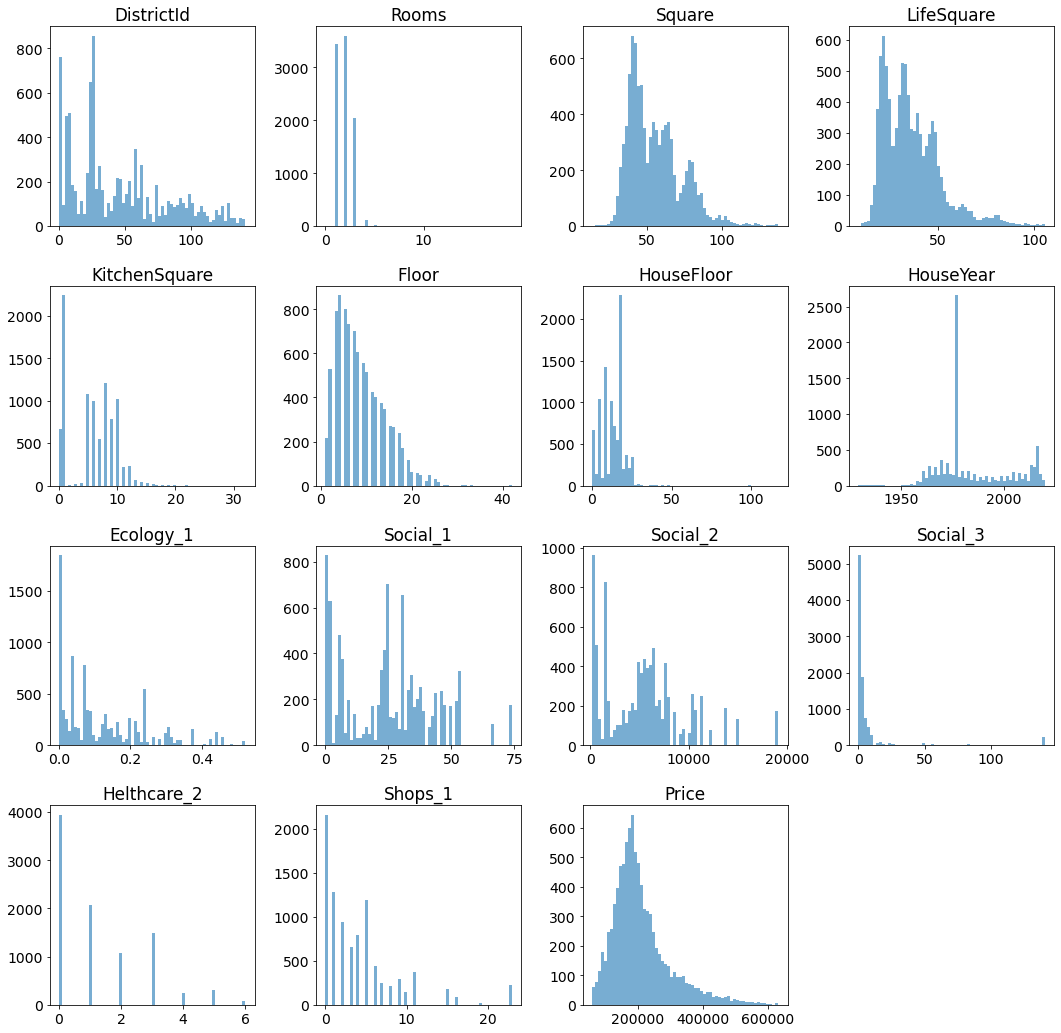

In [29]:
df_num.hist(figsize=(18,18), bins=62, grid=False, alpha=0.6);

## Заметная значимость по шкале Чеддока - при коэффициенте корреляции |0.5| и выше


Коэффициент корреляции 0.5477252459493276


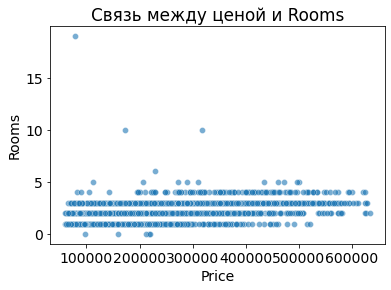

Коэффициент корреляции 0.6045884261927598


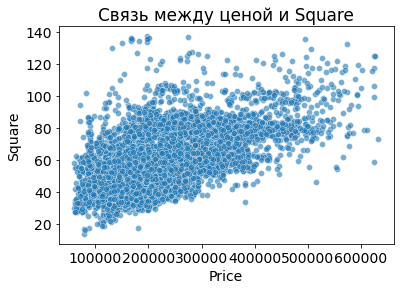

In [30]:
ched = 0.5

for i in df_num.columns[:-1]:
    c_corr = df_num[i].corr(df_num.Price)
    if abs(c_corr) >= ched:
        sns.scatterplot(x="Price", y=i, data=df_num, alpha=0.6)
        print("Коэффициент корреляции " + str(abs(c_corr)))
        plt.title("Связь между ценой и " + str(i))
        plt.show()

## Добавление признаков

In [31]:
cor_matrix = df.corr()
sorted_corr = cor_matrix['Price'][:-1].sort_values(ascending = False)
sorted_corr

Square           0.604588
Rooms            0.547725
LifeSquare       0.456342
KitchenSquare    0.318779
Social_1         0.279797
Social_2         0.254413
Helthcare_2      0.235970
DistrictId       0.218681
Shops_1          0.170546
Floor            0.143674
HouseFloor       0.120758
HouseYear        0.070521
Social_3         0.035487
Ecology_1       -0.058557
Name: Price, dtype: float64

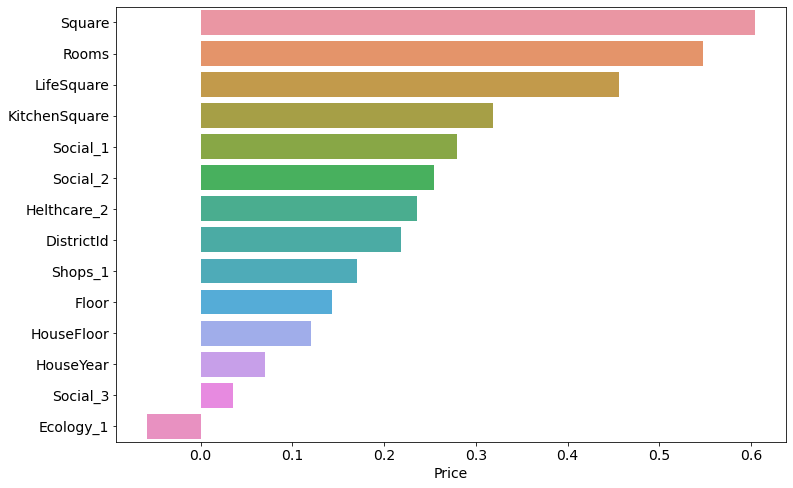

In [32]:
plt.figure(figsize=(12, 8))
sns.barplot(x=sorted_corr, y=sorted_corr.index);

In [33]:
df['first_flor'] = df['Floor']==1
df['lsast_flor'] = df['Floor']==df['HouseFloor']


In [34]:
district_size = df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})


In [35]:
df = df.merge(district_size, on='DistrictId', how='left')
df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,first_flor,lsast_flor,DistrictSize
0,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,B,...,33,7976,5,0,11,B,184966.937500,False,False,22
1,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,B,...,46,10309,1,1,16,B,300009.437500,False,False,87
2,53,2.0,44.947952,29.197611,0.0,8,12.0,1968,0.049637,B,...,34,7759,0,1,3,B,220925.906250,False,False,172
3,58,2.0,53.352982,52.731510,9.0,8,17.0,1977,0.437885,B,...,23,5735,3,0,5,B,175616.234375,False,False,173
4,99,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,B,...,35,5776,1,2,4,B,150226.531250,False,False,97


In [36]:
med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrict'})

In [37]:
df = df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
df

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,first_flor,lsast_flor,DistrictSize,MedPriceByDistrict
0,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,B,...,7976,5,0,11,B,184966.937500,False,False,22,207786.125000
1,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,B,...,10309,1,1,16,B,300009.437500,False,False,87,300009.437500
2,53,2.0,44.947952,29.197611,0.0,8,12.0,1968,0.049637,B,...,7759,0,1,3,B,220925.906250,False,False,172,262315.093750
3,58,2.0,53.352982,52.731510,9.0,8,17.0,1977,0.437885,B,...,5735,3,0,5,B,175616.234375,False,False,173,166809.671875
4,99,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,B,...,5776,1,2,4,B,150226.531250,False,False,97,158539.062500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9224,32,2.0,50.401787,30.476204,5.0,6,5.0,1968,0.135650,B,...,7960,6,3,11,B,196684.312500,False,False,34,233599.109375
9225,18,1.0,41.521545,20.539215,9.0,13,13.0,2000,0.000000,B,...,5562,0,0,5,A,189050.296875,False,True,51,171162.187500
9226,27,1.0,47.939007,28.763405,1.0,12,16.0,2015,0.072158,B,...,629,1,0,0,A,159143.812500,False,False,792,119443.812500
9227,75,2.0,43.602562,33.840149,8.0,1,5.0,1961,0.307467,B,...,5048,9,2,5,B,181595.343750,True,False,65,186453.109375


In [38]:
cor_matrix = df.corr()
sorted_corr = cor_matrix['Price'].sort_values(ascending = False)
sorted_corr

Price                 1.000000
MedPriceByDistrict    0.776867
Square                0.604588
Rooms                 0.547725
LifeSquare            0.456342
KitchenSquare         0.318779
Social_1              0.279797
Social_2              0.254413
Helthcare_2           0.235970
DistrictId            0.218681
Shops_1               0.170546
Floor                 0.143674
HouseFloor            0.120758
HouseYear             0.070521
Social_3              0.035487
lsast_flor           -0.015147
Ecology_1            -0.058557
first_flor           -0.060359
DistrictSize         -0.373670
Name: Price, dtype: float64

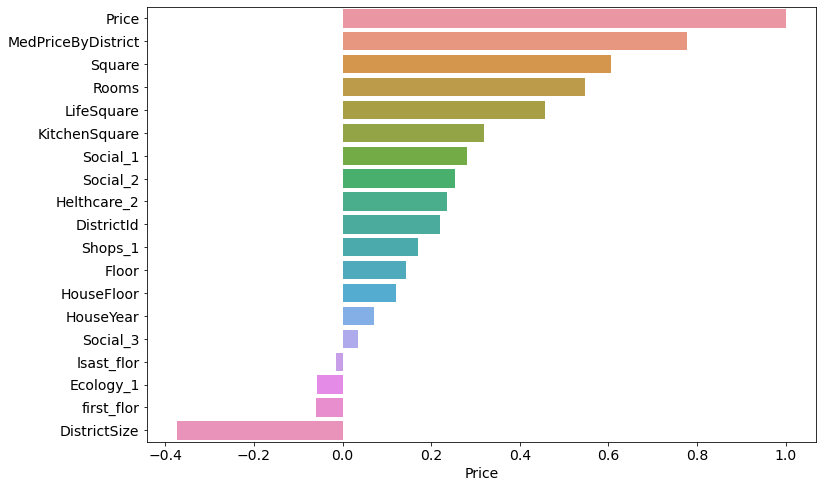

In [39]:
plt.figure(figsize=(12, 8))
sns.barplot(x=sorted_corr, y=sorted_corr.index);

Добавленая характеристика MedPriceByDistrict  вносит вполне ощутимый вклад в стоимость квартиры. Позже проверим влияние признаков после стандартизации (необходимо что бы все признаки имели равные возможности внести вклад в уравнение прямой)

## Матрица коряляций

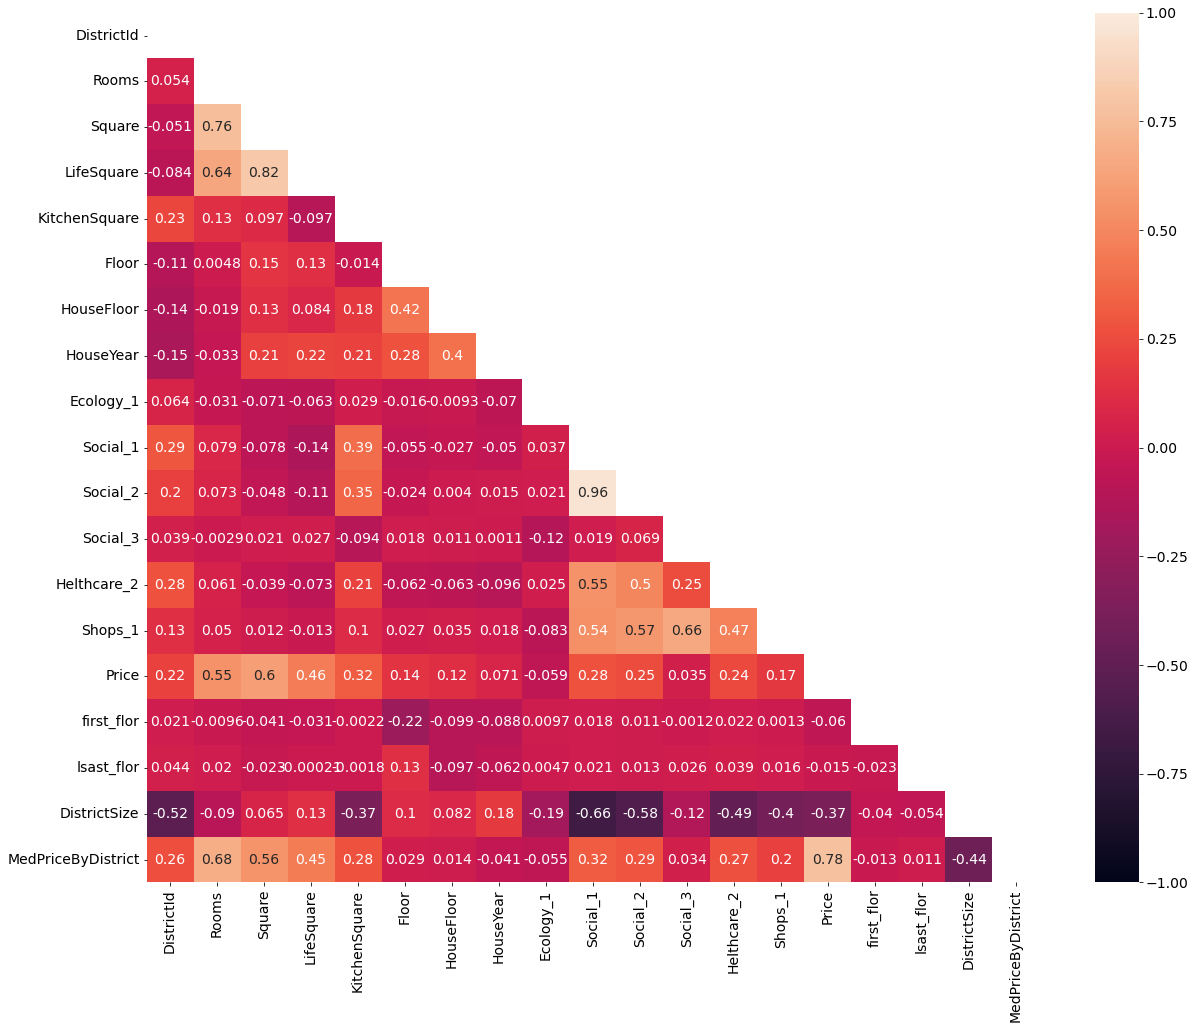

In [40]:
plt.figure(figsize=(20, 16))
mask = np.triu(df.corr())
sns.heatmap(df.corr(), center=0, annot=True, mask = mask, vmax=1, vmin=-1, cmap='rocket');

## Декодирование категориальных признаков в числовые

In [41]:
cat_columns = df.select_dtypes(include=['category','bool']).columns
list(cat_columns)

['Ecology_2', 'Ecology_3', 'Shops_2', 'first_flor', 'lsast_flor']

In [42]:
df = pd.get_dummies(df, columns=list(cat_columns))

In [43]:
sc=StandardScaler()
df_std = sc.fit_transform(df) # что бы реально оценить вклад признака в уравнение прямой
df_std2 = pd.DataFrame(df_std, columns=df.columns).copy()


In [44]:
cor_matrix = df_std2.corr()
sorted_corr = cor_matrix['Price'].sort_values(ascending = False)
sorted_corr

Price                 1.000000
MedPriceByDistrict    0.776867
Square                0.604588
Rooms                 0.547725
LifeSquare            0.456342
KitchenSquare         0.318779
Social_1              0.279797
Social_2              0.254413
Helthcare_2           0.235970
DistrictId            0.218681
Shops_1               0.170546
Floor                 0.143674
HouseFloor            0.120758
HouseYear             0.070521
Shops_2_B             0.068583
Ecology_3_A           0.063429
first_flor_False      0.060359
Social_3              0.035487
Ecology_2_B           0.019423
lsast_flor_False      0.015147
lsast_flor_True      -0.015147
Ecology_2_A          -0.019423
Ecology_1            -0.058557
first_flor_True      -0.060359
Ecology_3_B          -0.063429
Shops_2_A            -0.068583
DistrictSize         -0.373670
Name: Price, dtype: float64

Вклад стандартизированых признаков в уравнение линейной регресии


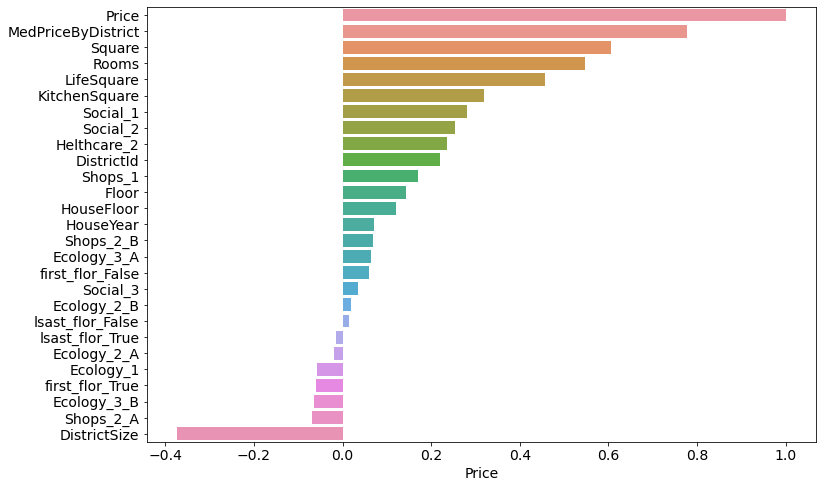

In [45]:
print('Вклад стандартизированых признаков в уравнение линейной регресии')
plt.figure(figsize=(12, 8))
sns.barplot(x=sorted_corr, y=sorted_corr.index);

In [46]:
mdict = dict(sorted_corr)
list_for_drop = []
for k, v in mdict.items():
    if v <= 0.070522 and v > -0.078580:
        list_for_drop.append(k)
        

In [47]:
df.drop(columns=list_for_drop, axis=1, inplace=True)

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9229 entries, 0 to 9228
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   DistrictId          9229 non-null   int16  
 1   Rooms               9229 non-null   float32
 2   Square              9229 non-null   float32
 3   LifeSquare          9229 non-null   float32
 4   KitchenSquare       9229 non-null   float32
 5   Floor               9229 non-null   int8   
 6   HouseFloor          9229 non-null   float32
 7   Social_1            9229 non-null   int8   
 8   Social_2            9229 non-null   int16  
 9   Helthcare_2         9229 non-null   int8   
 10  Shops_1             9229 non-null   int8   
 11  Price               9229 non-null   float32
 12  DistrictSize        9229 non-null   int64  
 13  MedPriceByDistrict  9229 non-null   float32
dtypes: float32(7), int16(2), int64(1), int8(4)
memory usage: 468.7 KB


## Автоматизация подачи данных

In [111]:
def load_data():
    DATASET_PATH = r'C:\Users\Оксана\Downloads\train.csv'
    PREPARED_DATASET_PATH = 'housing_prepared.csv'
    TEST = r'C:\Users\Оксана\Downloads\test.csv'
    df = pd.read_csv(DATASET_PATH, sep=',')
    return df

df = load_data()


In [112]:
def data_prepare_train(df, corr_threshhold=0.1):
    
    """Подготовка обучающего набора для обучения с отбрасывание
    признаков части признаков за счет установки corr_threshhold
    
    """
    
    #замена пропусков
    df['LifeSquare'].fillna(df['Square']*0.6, inplace=True)
    
    if 'Healthcare_1' in df.columns:
            df.drop('Healthcare_1', axis=1, inplace=True)
            
            
    if 'Id' in df.columns:
            df.drop('Id', axis=1, inplace=True)

    
    #замена вбросов и чистка дата фрейма
    df = df.loc[df['HouseYear']>1920]
    df = df.loc[df['DistrictId']<142]
    df = df.loc[df['Square']>7]
    df = df.loc[df['LifeSquare']>7]
    df = df.loc[df['HouseYear']<2023]
    df = df.loc[df['KitchenSquare']<100]
    df = df.loc[df['LifeSquare']<300]
    df = df.loc[df['Square']<600]
           
    feature_for_purifieng = ['Square', 'HouseYear', 'LifeSquare', 'KitchenSquare', 'Rooms']
    for el in feature_for_purifieng:
        Q1 = df[el].quantile(0.25)
        Q3 = df[el].quantile(0.75)
        IQR = Q3-Q1
        df = df[(df[el]<Q1-3*IQR)|(df[el]<Q3+2*IQR)]
        
    district_size = df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
    df = df.merge(district_size, on='DistrictId', how='left')
    
    med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrict'})
    df = df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
    
    cat_columns = df.select_dtypes(include=['category','bool','object']).columns
    
    df = pd.get_dummies(df, columns=cat_columns)
    
    
    sc=StandardScaler()
    df_std = sc.fit_transform(df) # что бы реально оценить вклад признака в уравнение прямой
    df_std2 = pd.DataFrame(df_std, columns=df.columns).copy()
    
    cor_matrix = df_std2.corr()
    sorted_corr = cor_matrix['Price'].sort_values(ascending = False)

    corr_dict = dict(sorted_corr)
    list_for_drop = []


    for k, v in corr_dict.items():
        if abs(v) < corr_threshhold:
            list_for_drop.append(k)     
        
    
    for el in list_for_drop:
        if el in df.columns:
            df.drop(columns=el, axis=1, inplace=True)
             
    drop_dict = {}       
    for k, v in corr_dict.items():
        if abs(v) < corr_threshhold:
            drop_dict[k] = v
            
    print(f' Удалены следующие признаки - {drop_dict}')  

    return df, list_for_drop

In [113]:
df, list_for_drop = data_prepare_train(df, corr_threshhold=0)

 Удалены следующие признаки - {}


## Разбиение на обучабщий и тестовый наборs

In [123]:
def train_test_scaller(df):
    
    y = df['Price']
    X = df.drop(['Price'], axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=99)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test, y_train, y_test

In [124]:
X_train, X_test, y_train, y_test = train_test_scaller(df)

## Функция для автоматического расчета метрик и визуализации обучения

In [87]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

## Модель случайного леса для регрисионого анализа (оптимизированая)

R2:	0.747
RMSE:	42541.495
MSE:	1809778756.284


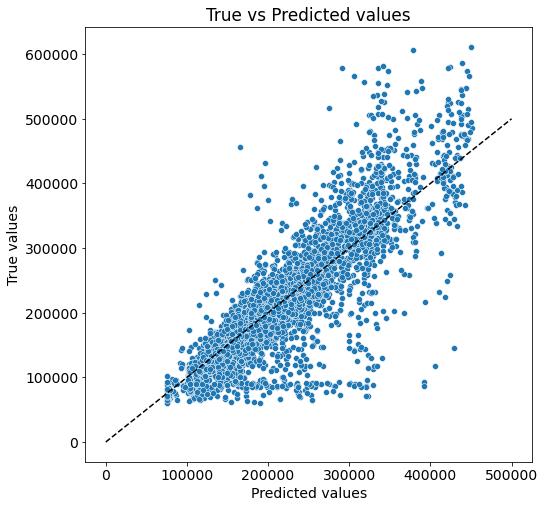

In [127]:
forest = RandomForestRegressor(criterion='mse',
                                 max_depth=30, # глубина дерева  
                                 min_samples_leaf=30, # минимальное кол-во наблюдений в листе дерева
                                 random_state=42,
                                 n_estimators=300  # кол-во деревьев
                                 )

forest.fit(X_train, y_train)
y_train_preds = forest.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.737
RMSE:	42679.08
MSE:	1821503883.833


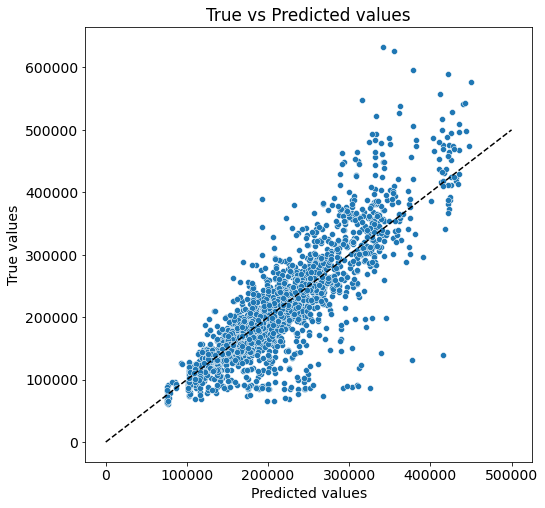

In [128]:
y_test_preds = forest.predict(X_test)
evaluate_preds(y_test, y_test_preds)

In [1294]:
def model_learning(model, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    model.fit(X_train, y_train)
    y_train_preds = model.predict(X_train)
    y_test_preds = tree.predict(X_test)
    return evaluate_preds(y_test, y_test_preds), evaluate_preds(y_train, y_train_preds)

## Предсказание на тесте

In [131]:
test = pd.read_csv(r'C:\Users\Оксана\Downloads\test.csv')

In [132]:
Id = test['Id']

In [133]:
def test_prepare(test, df):
    test['LifeSquare'].fillna(df['Square']*0.6, inplace=True)
    
    if 'Healthcare_1' in test.columns:
        test.drop('Healthcare_1', axis=1, inplace=True)
            
            
    if 'Id' in test.columns:
        test.drop('Id', axis=1, inplace=True)

    med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
    .rename(columns={'Price':'MedPriceByDistrict'})
    test = test.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
    
    district_size = df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
    test = test.merge(district_size, on='DistrictId', how='left')
    
    cat_columns = test.select_dtypes(include=['category','bool','object']).columns
    
    test = pd.get_dummies(test, columns=cat_columns)
    
    for el in list_for_drop:
        if el in test.columns:
            test.drop(columns=el, axis=1, inplace=True) 
    return test        
 

In [134]:
test = test_prepare(test, df)
test

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Helthcare_2,Shops_1,MedPriceByDistrict,DistrictSize,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
0,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,11,...,0,0,167447.985285,169.0,0,1,0,1,0,1
1,74,2.0,69.263183,39.410184,1.0,6,1.0,1977,0.075779,6,...,0,2,242515.793425,101.0,0,1,0,1,0,1
2,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,30,...,5,5,NaN,NaN,0,1,0,1,0,1
3,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,23,...,3,3,222227.584211,97.0,0,1,0,1,0,1
4,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,2,...,0,0,119443.814919,772.0,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,11,3.0,67.133911,50.809797,6.0,5,9.0,1973,0.000170,36,...,1,1,247249.090873,127.0,0,1,0,1,0,1
4996,1,1.0,40.198472,21.807061,10.0,12,17.0,2017,0.007122,1,...,0,1,146271.160982,622.0,0,1,0,1,0,1
4997,12,3.0,77.842178,48.282625,9.0,23,22.0,1989,0.090799,74,...,5,15,315198.842627,64.0,0,1,0,1,0,1
4998,62,2.0,81.305222,40.337312,0.0,4,0.0,1977,0.072158,2,...,0,0,179361.240076,215.0,0,1,0,1,1,0


In [135]:
test.isnull().sum()*100/test.shape[0]

DistrictId            0.00
Rooms                 0.00
Square                0.00
LifeSquare            0.00
KitchenSquare         0.00
Floor                 0.00
HouseFloor            0.00
HouseYear             0.00
Ecology_1             0.00
Social_1              0.00
Social_2              0.00
Social_3              0.00
Helthcare_2           0.00
Shops_1               0.00
MedPriceByDistrict    7.22
DistrictSize          5.00
Ecology_2_A           0.00
Ecology_2_B           0.00
Ecology_3_A           0.00
Ecology_3_B           0.00
Shops_2_A             0.00
Shops_2_B             0.00
dtype: float64

In [136]:
test = test.fillna(test['MedPriceByDistrict'].median())
test = test.fillna(test['DistrictSize'].median())

In [137]:
test.isnull().sum()*100/test.shape[0]

DistrictId            0.0
Rooms                 0.0
Square                0.0
LifeSquare            0.0
KitchenSquare         0.0
Floor                 0.0
HouseFloor            0.0
HouseYear             0.0
Ecology_1             0.0
Social_1              0.0
Social_2              0.0
Social_3              0.0
Helthcare_2           0.0
Shops_1               0.0
MedPriceByDistrict    0.0
DistrictSize          0.0
Ecology_2_A           0.0
Ecology_2_B           0.0
Ecology_3_A           0.0
Ecology_3_B           0.0
Shops_2_A             0.0
Shops_2_B             0.0
dtype: float64

In [139]:
sc = StandardScaler()

In [140]:
test = sc.fit_transform(test)

In [141]:
y = forest.predict(test)

In [142]:
answer = pd.DataFrame({'Id':Id})

In [143]:
answer['Price'] = y

In [144]:
answer

,Id,Price
0,725,180937.482451
1,15856,199206.380232
2,5480,310242.845693
3,15664,210684.143909
4,14275,194029.621649
...,...,...
4995,8180,194087.821860
4996,4695,190257.421240
4997,5783,208391.296251
4998,4780,203566.217774


In [145]:
answer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      5000 non-null   int64  
 1   Price   5000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 78.2 KB


In [146]:
PREPARED_DATASET_PATH = 'answer2.csv'

answer.to_csv(PREPARED_DATASET_PATH, index=False)

## Выводы 
* Были добавлены новые признаки такие как Размер округа и Медианая цена по району, верхний и нижней этаж
* При сравнении 3 моделей (Линейная регресия, Лес, Случайный лес) с различными методами оптимизации был выбран алгаритм случайного леса (который на самом деле не сильно эфективней линейной регресии в среднем на 0.05 ед ниже чем для случайный лес но значительно быстрее) с помощью решетчатого поиска были подобраны гиперпарметры случайного леса
* Наюлюдаем сильную кореляцию между признакими 
* Наибольший вклад в уравнене прямой имеют такие признаки как площадь и количество комнат по чедаку, а так же добавленый новый признак средней цены квартиры по району 
* В целом было расмотрено добавление и удаление признаков. Удаление как и следовало ожидать несколько уменьшает коэфицент корреляции поскольку метрикой не является скоректированый коэфицент кореляции оставим признаки.